In [1]:
import sys
sys.path.append('./code')
import torch
import cv2
import torch.nn as nn
import numpy as np
import argparse
from vgg_face import *
import matplotlib.pyplot as plt
from facegenDataset import *
from FAUDataset import *

def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
        param.requires_grad = False if feature_extracting else True

def test_model(model, crop_frame, device):
    model.eval()
    with torch.no_grad():
        crop_frame = cv2.cvtColor(crop_frame, cv2.COLOR_BGR2RGB)
        crop_frame = cv2.resize(crop_frame, (224, 224))
        crop_frame = crop_frame / 255.0
        crop_frame = np.transpose(crop_frame, (2, 0, 1))
        crop_frame = np.expand_dims(crop_frame, axis=0)  # add batch dimension
        crop_frame = torch.from_numpy(crop_frame).float().to(device)

        output = model(crop_frame)
        output = output * torch.FloatTensor([16] + [5]*10).to(device)
    return output

num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = VGG_16().to(device)
set_parameter_requires_grad(model, feature_extracting=False)
num_ftrs = model.fc8.in_features
model.fc8 = nn.Linear(num_ftrs, num_classes).to(device)
model.load_state_dict(torch.load('/Users/miguelmonares/Downloads/checkpoint_epoch69_r20.pth', map_location=device))

<All keys matched successfully>

In [2]:
crop_frame = cv2.imread('/Users/miguelmonares/Downloads/4em1_4.10.png')

cv2.imshow('img',crop_frame)

In [3]:
output = test_model(model, crop_frame, device)

output = output.flatten()
print(output)

tensor([ 5.3911,  5.3574,  0.0265,  0.0239, -0.0793, -0.0060,  0.0086,  0.0355,
        -0.0169, -0.1253,  0.0252], device='mps:0')


/Users/miguelmonares/Desktop/CS/deSa-lab/venv/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  nonzero_finite_vals = torch.masked_select(


In [4]:
output_text = '|PSPI {:.2f} |au4 {:.2f} |au6 {:.2f} |au7 {:.2f} |au10 {:.2f} |au12 {:.2f} |au20 {:.2f} |au25 {:.2f} |au26 {:.2f} |au43 {:.2f}|'.format(output[0].item(), output[1].item(), output[2].item(), output[3].item(), output[4].item(), output[5].item(), output[6].item(), output[7].item(), output[8].item(), output[9].item())

In [5]:
output_text

'|PSPI 5.39 |au4 5.36 |au6 0.03 |au7 0.02 |au10 -0.08 |au12 -0.01 |au20 0.01 |au25 0.04 |au26 -0.02 |au43 -0.13|'

In [6]:
crop_frame2 = cv2.imread('/Users/miguelmonares/FAU2/images/European_Man/em1/4em1_4.10.png')
output = test_model(model, crop_frame2, device)

output = output.flatten()
output_text = '|PSPI {:.2f} |au4 {:.2f} |au6 {:.2f} |au7 {:.2f} |au10 {:.2f} |au12 {:.2f} |au20 {:.2f} |au25 {:.2f} |au26 {:.2f} |au43 {:.2f}|'.format(output[0].item(), output[1].item(), output[2].item(), output[3].item(), output[4].item(), output[5].item(), output[6].item(), output[7].item(), output[8].item(), output[9].item())
output_text

'|PSPI 5.33 |au4 5.30 |au6 0.03 |au7 0.03 |au10 -0.09 |au12 -0.00 |au20 0.03 |au25 0.05 |au26 -0.04 |au43 -0.14|'

In [7]:
import os
import cv2

def process_images_in_folder(model, folder_path, device, output_file):
    # Get a list of image file names in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.jpg')]

    with open(output_file, 'w') as f:
        for image_file in image_files:
            # Read the image
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path)

            # Process the image using the model
            output = test_model(model, image, device)

            output = output.flatten()
            output_text = '|PSPI {:.2f} |au4 {:.2f} |au6 {:.2f} |au7 {:.2f} |au9 {:.2f} |au10 {:.2f} |au12 {:.2f} |au20 {:.2f} |au25 {:.2f} |au26 {:.2f} |au43 {:.2f}|'.format(output[0].item(), output[1].item(), output[2].item(), output[3].item(), output[4].item(), output[5].item(), output[6].item(), output[7].item(), output[8].item(), output[9].item(), output[10].item())
            # Write the output to the file
            f.write(f'{image_file}: {output_text}\n')

    print(f"Processing complete. Output saved to {output_file}")

In [8]:
folder_path = '/Users/miguelmonares/FAU2/images/European_Man/em1'
output_file = 'mig_output.txt'

process_images_in_folder(model, folder_path, device, output_file)

Processing complete. Output saved to mig_output.txt


In [9]:
import os
import cv2
import pandas as pd

df_1 = []
df_10 = []
def process_images_in_folder(model, folder_path, device, output_file, df_out):
    # Get a list of image file names in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.jpg')]

    # Create an empty list to store the data
    data = []

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Process the image using the model
        output = test_model(model, image, device)
        output = output.flatten()
        # Create a dictionary with the image name and output values
        row = {
            'Image': image_file,
            'PSPI': output[0].item(),
            'AU4': output[1].item(),
            'AU6': output[2].item(),
            'AU7': output[3].item(),
            'AU9': output[4].item(),
            'AU10': output[5].item(),
            'AU12': output[6].item(),
            'AU20': output[7].item(),
            'AU25': output[8].item(),
            'AU26': output[9].item(),
            'AU43': output[10].item()
        }

        # Append the row to the data list
        data.append(row)

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    # Sort the DataFrame by the 'Image' column in alphabetical order
    df = df.sort_values(by='Image')

    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=False)

    print(f"Processing complete. Output saved to {output_file}")


In [10]:
folder_path = '/Users/miguelmonares/FAU2/images/European_Man/em1'
output_file = 'mig_output.csv'

process_images_in_folder(model, folder_path, device, output_file, df_1)

Processing complete. Output saved to mig_output.csv


In [11]:
df_1 = pd.read_csv('mig_output.csv')
df_10 = pd.read_csv('mig_output10.csv')

In [12]:
df_10

,Image,PSPI,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU25,AU26,AU43
0,10em10_10.10.png,5.278227,0.230042,0.080546,0.118027,0.563322,4.491800,0.174737,-0.082028,-0.032275,-0.114363,0.013824
1,10em10_10.2.png,1.792207,0.457025,0.083433,0.631998,0.163884,0.539825,0.221008,0.030133,0.042238,-0.171278,-0.012350
2,10em10_10.4.png,2.710463,0.249163,0.154059,0.290394,0.410917,1.768276,0.203138,-0.061915,-0.062915,-0.122297,-0.001930
3,10em10_10.6.png,3.625968,0.213049,0.090917,0.157570,0.485125,2.856376,0.227481,-0.064924,-0.060994,-0.116081,0.004765
4,10em10_10.8.png,4.523839,0.217161,0.085320,0.121203,0.464861,3.824720,0.177509,-0.068349,-0.038979,-0.117242,0.011805
5,12em10_12.10.png,0.704714,0.144037,-0.035777,0.560176,0.075844,0.037589,4.698996,-0.058394,-0.060406,-0.086805,-0.000346
6,12em10_12.2.png,1.338383,0.357633,-0.040400,1.059817,-0.015922,0.016661,1.172007,0.071369,-0.061234,-0.170397,-0.019026
7,12em10_12.4.png,1.090442,0.268457,-0.090414,0.992547,-0.020949,-0.018445,2.160621,-0.003693,-0.037106,-0.159383,-0.021694
8,12em10_12.6.png,0.882414,0.202695,-0.084959,0.799701,0.006579,0.018882,3.101992,-0.052417,-0.035955,-0.131635,-0.019514
9,12em10_12.8.png,0.798271,0.178630,-0.058474,0.667077,0.067547,0.029337,3.979303,-0.063931,-0.060179,-0.102123,-0.008078


In [13]:
df_1

,Image,PSPI,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU25,AU26,AU43
0,10em1_10.10.png,4.935732,0.099373,-0.099792,0.050998,0.088903,4.820740,0.005943,-0.026657,0.007448,-0.079789,0.038740
1,10em1_10.2.png,0.992268,0.228827,-0.068446,0.240622,0.112441,0.472433,0.116708,-0.001945,0.013115,-0.085766,0.036407
2,10em1_10.4.png,2.041370,0.084576,-0.060837,0.080185,0.200179,1.796413,0.024996,-0.016592,-0.027686,-0.064928,0.016666
3,10em1_10.6.png,3.064374,0.075660,-0.078815,0.048934,0.139216,2.924344,-0.012691,-0.015823,-0.010287,-0.060678,0.024123
4,10em1_10.8.png,4.027164,0.087927,-0.094698,0.042186,0.097210,3.915153,-0.013396,-0.017340,0.004670,-0.068279,0.033300
5,12em1_12.10.png,0.131221,0.035279,-0.111066,0.217730,-0.025141,-0.051426,5.101875,-0.055605,0.006948,-0.086528,0.017256
6,12em1_12.2.png,0.582183,0.178038,-0.127598,0.511801,-0.017078,-0.020478,1.064086,0.051911,-0.049761,-0.093265,0.042445
7,12em1_12.4.png,0.348940,0.111177,-0.143340,0.391410,-0.017656,-0.039087,2.116625,0.000048,-0.013997,-0.098720,0.027107
8,12em1_12.6.png,0.184668,0.070922,-0.117545,0.263081,-0.015429,-0.042078,3.107649,-0.030051,0.004980,-0.080233,0.013619
9,12em1_12.8.png,0.132008,0.047946,-0.100964,0.213412,-0.015716,-0.057760,4.204083,-0.047781,0.006698,-0.079337,0.008611


In [14]:
from scipy.stats import ttest_rel

def paired_ttest_between_dataframes(df1, df2):
    # Get the column names common to both DataFrames
    common_columns = [col for col in df1.columns if col in df2.columns]

    # Perform paired t-test for each common column
    results = {}
    for col in common_columns[1:]:
        # Extract the column data from both DataFrames
        data1 = df1[col]
        data2 = df2[col]
        print(data1)
        print(data2)
        # Perform paired t-test
        t_statistic, p_value = ttest_rel(data1, data2)

        # Store the results
        results[col] = {'t-statistic': t_statistic, 'p-value': p_value}

    return results

In [15]:
results = paired_ttest_between_dataframes(df_1,df_10)

0     4.935732
1     0.992268
2     2.041370
3     3.064374
4     4.027164
5     0.131221
6     0.582183
7     0.348940
8     0.184668
9     0.132008
10    0.189103
11    0.644780
12    0.508362
13    0.384866
14    0.287520
15    0.171061
16    0.753625
17    0.523118
18    0.353594
19    0.230599
20    0.156819
21    0.883387
22    0.720040
23    0.453216
24    0.275719
25    1.386638
26    5.331400
27    1.667328
28    2.922378
29    4.039784
30    4.767920
31    4.323248
32    1.264739
33    1.858227
34    2.780051
35    3.514032
36    4.663945
37    1.612633
38    2.695270
39    3.398682
40    4.364223
41    5.399135
42    1.239591
43    2.239688
44    3.292253
45    4.396599
46    0.794055
Name: PSPI, dtype: float64
0     5.278227
1     1.792207
2     2.710463
3     3.625968
4     4.523839
5     0.704714
6     1.338383
7     1.090442
8     0.882414
9     0.798271
10    0.581499
11    1.251818
12    1.059750
13    0.888452
14    0.702430
15    0.625723
16    1.404144
17    1.16283

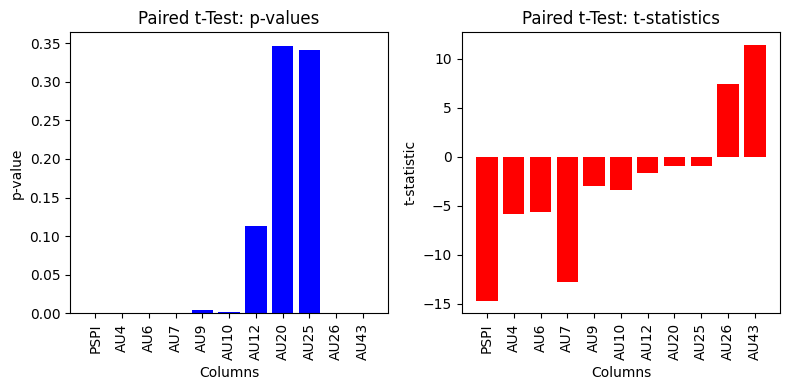

In [16]:
import matplotlib.pyplot as plt

def plot_ttest_results(results):
    columns = list(results.keys())
    p_values = [result['p-value'] for result in results.values()]
    t_statistics = [result['t-statistic'] for result in results.values()]

    # Plotting the p-values
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.bar(columns, p_values, color='blue')
    plt.xlabel('Columns')
    plt.ylabel('p-value')
    plt.title('Paired t-Test: p-values')
    plt.xticks(rotation=90)

    # Plotting the t-statistics
    plt.subplot(1, 2, 2)
    plt.bar(columns, t_statistics, color='red')
    plt.xlabel('Columns')
    plt.ylabel('t-statistic')
    plt.title('Paired t-Test: t-statistics')
    plt.xticks(rotation=90)

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.savefig('kdd-t-test.pdf')

    plt.show()

# Assuming you have obtained the 'results' dictionary from the paired_ttest_between_dataframes function

# Call the function to plot the results
plot_ttest_results(results)

In [17]:
from tabulate import tabulate

def organize_ttest_results(results):
    columns = list(results.keys())
    p_values = [result['p-value'] for result in results.values()]
    t_statistics = [result['t-statistic'] for result in results.values()]

    # Create a table with the results
    table = []
    for col, p_value, t_statistic in zip(columns, p_values, t_statistics):
        table.append([col, p_value, t_statistic])

    # Print the table
    print(tabulate(table, headers=['Column', 'p-value', 't-statistic'], tablefmt='grid'))

In [18]:
# Assuming you have obtained the 'results' dictionary from the paired_ttest_between_dataframes function

# Call the function to organize and print the results in a table format
organize_ttest_results(results)

+----------+-------------+---------------+
| Column   |     p-value |   t-statistic |
+==========+=============+===============+
| PSPI     | 5.1595e-19  |    -14.713    |
+----------+-------------+---------------+
| AU4      | 4.72062e-07 |     -5.85827  |
+----------+-------------+---------------+
| AU6      | 1.11425e-06 |     -5.60835  |
+----------+-------------+---------------+
| AU7      | 1.03877e-16 |    -12.7535   |
+----------+-------------+---------------+
| AU9      | 0.00455051  |     -2.98338  |
+----------+-------------+---------------+
| AU10     | 0.00135073  |     -3.41276  |
+----------+-------------+---------------+
| AU12     | 0.112856    |     -1.61635  |
+----------+-------------+---------------+
| AU20     | 0.346493    |     -0.951162 |
+----------+-------------+---------------+
| AU25     | 0.341532    |     -0.96109  |
+----------+-------------+---------------+
| AU26     | 1.71813e-09 |      7.48454  |
+----------+-------------+---------------+
| AU43     

In [77]:
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model1 = VGG_16().to(device)
set_parameter_requires_grad(model1, feature_extracting=False)
num_ftrs = model1.fc8.in_features
model1.fc8 = nn.Linear(num_ftrs, num_classes).to(device)
model1.load_state_dict(torch.load('/Users/miguelmonares/Downloads/checkpoint_epoch69_r22.pth', map_location=device))

<All keys matched successfully>

In [78]:
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model2 = VGG_16().to(device)
set_parameter_requires_grad(model2, feature_extracting=False)
num_ftrs = model2.fc8.in_features
model2.fc8 = nn.Linear(num_ftrs, num_classes).to(device)
model2.load_state_dict(torch.load('/Users/miguelmonares/Downloads/checkpoint_epoch69_r23.pth', map_location=device))

<All keys matched successfully>

In [123]:
import os
import cv2
import pandas as pd

def process_images(folder_path, model, device):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter files starting with '4' and exclude those starting with '43'
    image_files = [file for file in files if file.startswith('4') and not file.startswith('43')]

    # Initialize an empty list to hold the data
    data = []
    image_files = sorted(image_files)
    image_files.append(image_files.pop(0))
    for image_file in image_files:
        # Read the image
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Process the image using the model
        output = test_model(model, image, device)
        output = output.flatten()

        # Create a dictionary with the image name and output values
        row = {
            'Image': image_file,
            'PSPI': output[0].item(),
            'AU4': output[1].item(),
            'AU6': output[2].item(),
            'AU7': output[3].item(),
            'AU9': output[4].item(),
            'AU10': output[5].item(),
            'AU12': output[6].item(),
            'AU20': output[7].item(),
            'AU25': output[8].item(),
            'AU26': output[9].item(),
            'AU43': output[10].item()
        }

        # Append the row to the data list
        data.append(row)

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    # Print the DataFrame
    #print(df)

    # Return the DataFrame
    return df


In [22]:
m1_df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew1', model1, device)
m1_df

,Image,PSPI,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU25,AU26,AU43
0,4ew1_4.2.png,0.280849,0.503524,-0.001362,0.159889,-0.098904,0.047367,0.041670,0.385265,3.074796,-0.136522,0.013845
1,4ew1_4.4.png,0.679905,1.029185,0.006098,0.163755,-0.164513,0.041309,0.021901,0.387474,2.971070,-0.120470,-0.016054
2,4ew1_4.6.png,1.347569,1.765178,0.041768,0.105015,-0.232985,0.051206,0.025658,0.361647,2.805557,-0.108456,-0.039139
3,4ew1_4.8.png,2.146807,2.569227,0.095826,0.128601,-0.307663,0.068347,0.011862,0.350290,2.650284,-0.088237,-0.068709
4,4ew1_4.10.png,2.955949,3.281537,0.097788,0.304827,-0.371900,0.086294,-0.012144,0.316302,2.527944,-0.085180,-0.067249


In [23]:
import matplotlib.pyplot as plt

def plot_line_plots(df):
    columns = df.columns[1:]  # Exclude the 'Image' column
    i = 0
    for column in columns:
        print(column)
        if i == 2:
            return
        plt.figure(figsize=(8, 6))
        plt.title(column)

        # Get the values from the column
        values = df[column]

        # Plot the line plot
        plt.plot(values, marker='o')
        plt.xlabel('Index')
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()
        i += 1

PSPI


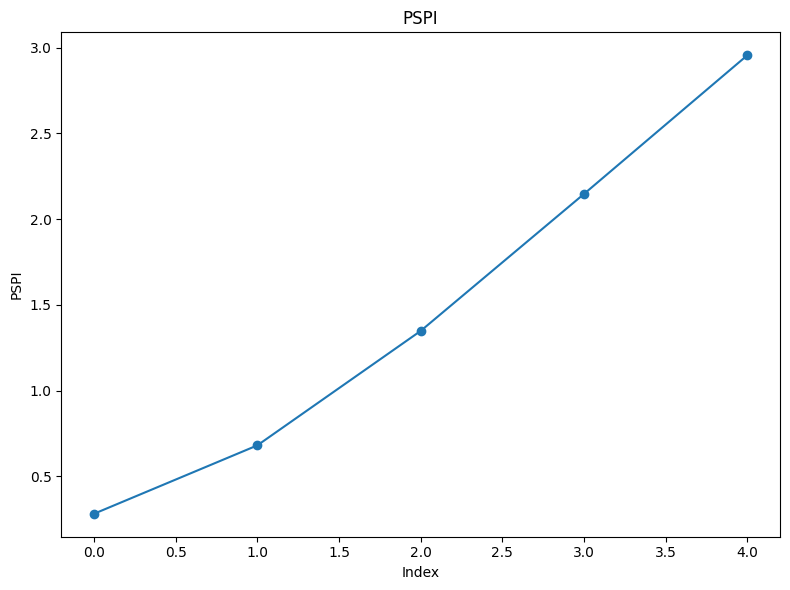

AU4


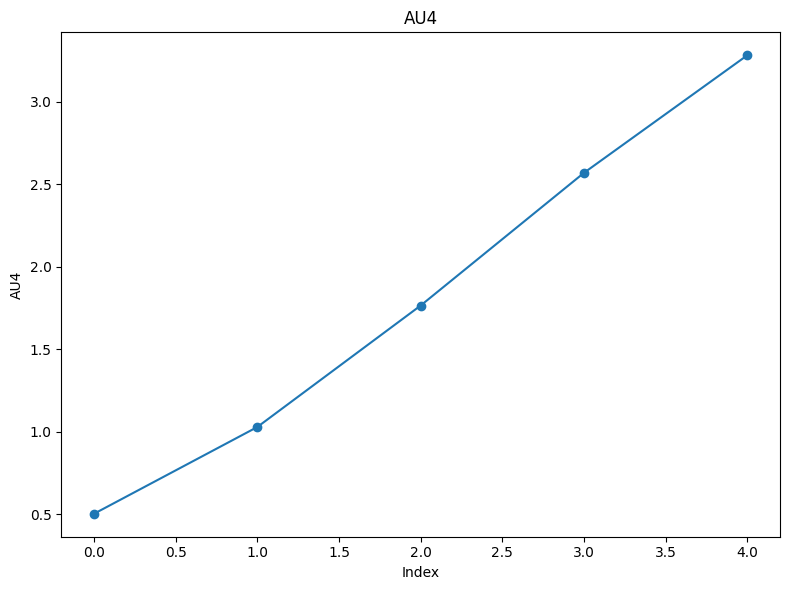

AU6


In [24]:
plot_line_plots(m1_df)

In [25]:
m1_df

,Image,PSPI,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU25,AU26,AU43
0,4ew1_4.2.png,0.280849,0.503524,-0.001362,0.159889,-0.098904,0.047367,0.041670,0.385265,3.074796,-0.136522,0.013845
1,4ew1_4.4.png,0.679905,1.029185,0.006098,0.163755,-0.164513,0.041309,0.021901,0.387474,2.971070,-0.120470,-0.016054
2,4ew1_4.6.png,1.347569,1.765178,0.041768,0.105015,-0.232985,0.051206,0.025658,0.361647,2.805557,-0.108456,-0.039139
3,4ew1_4.8.png,2.146807,2.569227,0.095826,0.128601,-0.307663,0.068347,0.011862,0.350290,2.650284,-0.088237,-0.068709
4,4ew1_4.10.png,2.955949,3.281537,0.097788,0.304827,-0.371900,0.086294,-0.012144,0.316302,2.527944,-0.085180,-0.067249


In [26]:
m2_df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew1', model2, device)
m2_df

,Image,PSPI,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU25,AU26,AU43
0,4ew1_4.2.png,0.110218,0.237444,-0.015263,-0.078827,-0.069091,0.070321,0.147672,0.422517,2.851244,-0.152238,0.055232
1,4ew1_4.4.png,0.390937,0.538157,-0.032666,-0.052833,-0.079445,0.062600,0.125038,0.421690,2.842768,-0.150472,0.041237
2,4ew1_4.6.png,0.902005,1.040632,-0.063991,-0.018538,-0.105243,0.079163,0.107148,0.416671,2.746935,-0.126549,0.029355
3,4ew1_4.8.png,1.518422,1.673289,-0.070093,0.026756,-0.157606,0.106744,0.094774,0.427633,2.635909,-0.100724,-0.002549
4,4ew1_4.10.png,2.209673,2.353453,-0.096116,0.124997,-0.208226,0.131682,0.073018,0.439375,2.558599,-0.065331,-0.015282


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def plot_columns_together(df1, df2, column_name):
    # Get the values from the specified column in both DataFrames
    values1 = df1[column_name]
    values2 = df2[column_name]

    # Calculate the mean absolute difference
    mean_abs_diff = np.mean(np.abs(values1 - values2))

    # Calculate the cosine similarity
    cosine_sim = cosine_similarity(values1.values.reshape(1, -1), values2.values.reshape(1, -1))[0, 0]

    # Perform linear regression on each dataset
    slope1, _ = np.polyfit(range(len(values1)), values1, 1)
    slope2, _ = np.polyfit(range(len(values2)), values2, 1)
    print(f"Slope of DataFrame 1: {slope1:.4f}")
    print(f"Slope of DataFrame 2: {slope2:.4f}")
    print()

    # Plot the values from both DataFrames on the same plot
    plt.figure(figsize=(8, 6))
    plt.plot(values1, label='DataFrame 1', marker='o')
    plt.plot(values2, label='DataFrame 2', marker='o')
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f"{column_name} Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Mean Absolute Difference: {mean_abs_diff:.4f}")
    print(f"Cosine Similarity: {cosine_sim:.4f}")


Slope of DataFrame 1: 0.6817
Slope of DataFrame 2: 0.5326



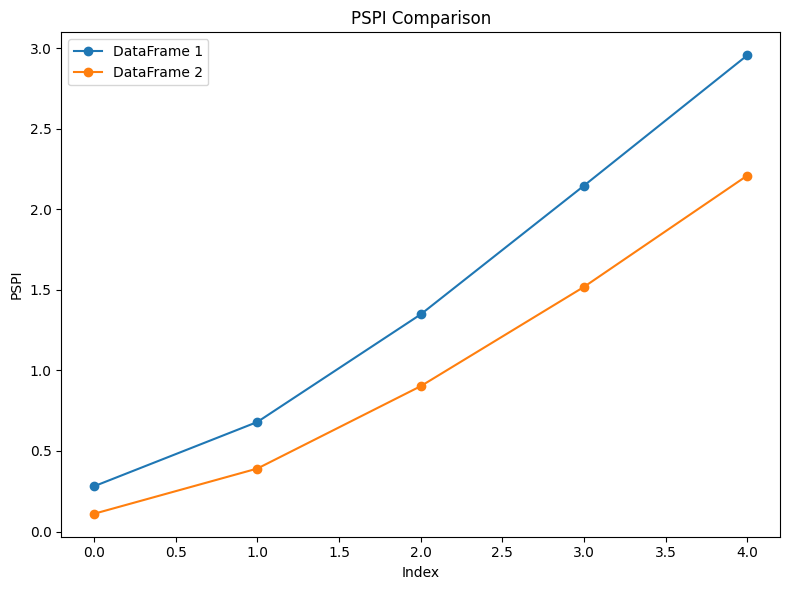

Mean Absolute Difference: 0.4560
Cosine Similarity: 0.9981


In [28]:
plot_columns_together(m1_df,m2_df,'PSPI')

In [29]:
m1_10df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew10', model1, device)
m2_10df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew10', model2, device)

Slope of DataFrame 1: 0.7096
Slope of DataFrame 2: 0.2865



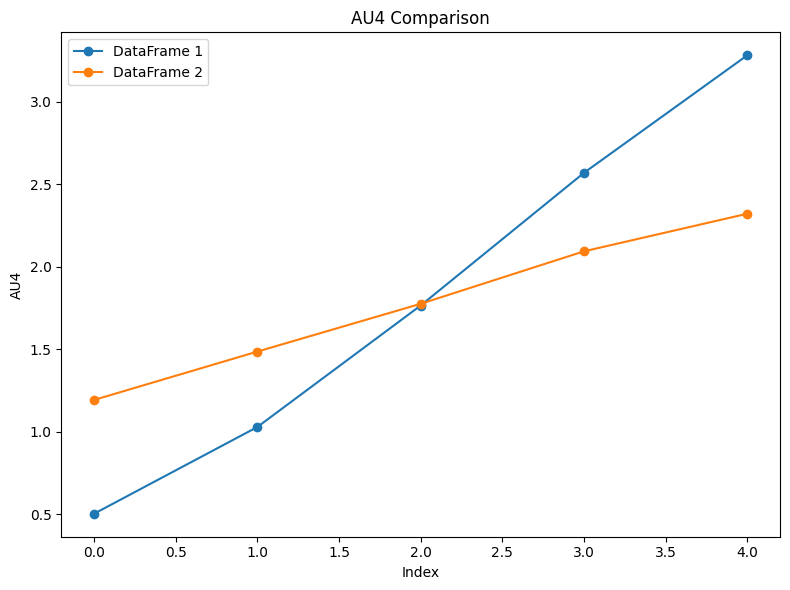

Mean Absolute Difference: 0.5185
Cosine Similarity: 0.9612
Slope of DataFrame 1: 0.5367
Slope of DataFrame 2: 0.6416



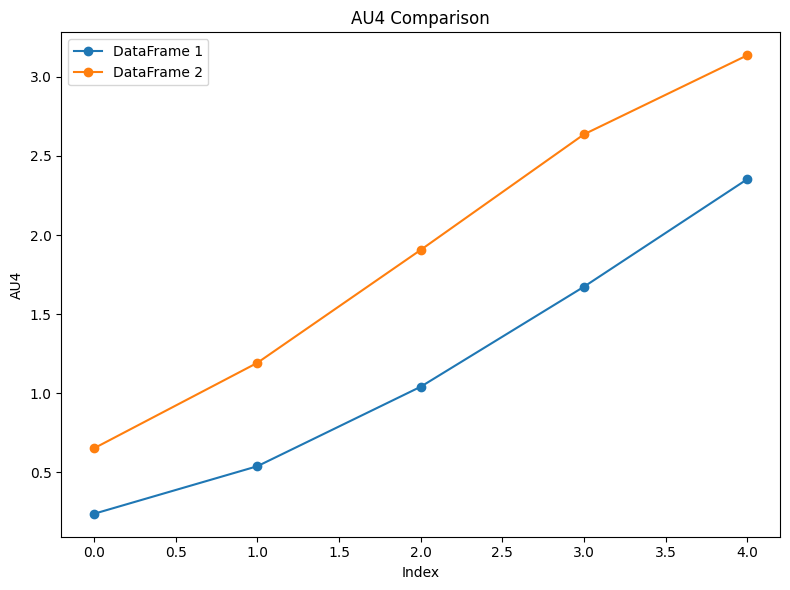

Mean Absolute Difference: 0.7359
Cosine Similarity: 0.9882


In [30]:
plot_columns_together(m1_df,m1_10df,'AU4')
plot_columns_together(m2_df,m2_10df, 'AU4')

Compare Model (1-5) vs (6-10) on EW1

Slope of DataFrame 1: 0.7096
Slope of DataFrame 2: 0.5367



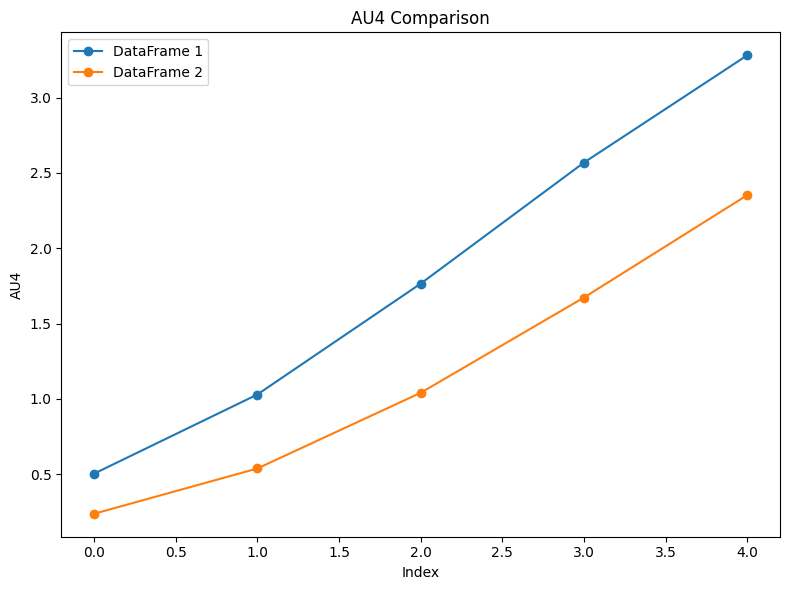

Mean Absolute Difference: 0.6611
Cosine Similarity: 0.9959


In [31]:
plot_columns_together(m1_df, m2_df, 'AU4')

Compare Model (1-5) vs (6-10) on EW10

Slope of DataFrame 1: 0.2865
Slope of DataFrame 2: 0.6416



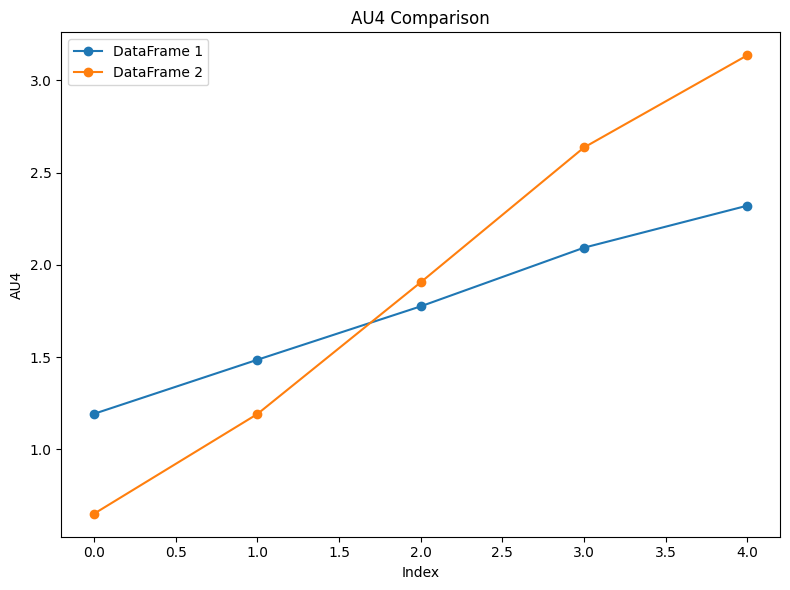

Mean Absolute Difference: 0.4649
Cosine Similarity: 0.9757


In [32]:
plot_columns_together(m1_10df, m2_10df, 'AU4')

In [33]:
m2_10df

,Image,PSPI,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU25,AU26,AU43
0,4ew10_4.2.png,0.340927,0.651340,-0.032806,-0.186889,-0.123959,0.086353,0.276981,0.435502,1.901272,0.063597,-0.030858
1,4ew10_4.4.png,0.823020,1.191819,-0.033382,-0.183739,-0.171613,0.090378,0.256214,0.444815,1.861824,0.075011,-0.029788
2,4ew10_4.6.png,1.546397,1.905772,-0.051896,-0.130370,-0.227153,0.107146,0.223466,0.459321,1.779491,0.090355,-0.031106
3,4ew10_4.8.png,2.298987,2.636869,-0.059929,-0.066326,-0.274565,0.124071,0.191423,0.466463,1.687469,0.114335,-0.038756
4,4ew10_4.10.png,2.848156,3.136808,-0.078578,0.039327,-0.310668,0.138180,0.163008,0.471987,1.610649,0.152761,-0.035478


In [158]:
num_classes = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model3 = VGG_16().to(device)
set_parameter_requires_grad(model3, feature_extracting=False)
num_ftrs = model3.fc8.in_features
model3.fc8 = nn.Linear(num_ftrs, num_classes).to(device)
model3.load_state_dict(torch.load('/Users/miguelmonares/Downloads/checkpoint_epoch69_r25.pth', map_location=device))

<All keys matched successfully>

In [80]:
m1_df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew1', model1, device)
m1_2df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew2', model1, device)
m1_3df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew3', model1, device)
m1_4df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew4', model1, device)
m1_5df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew5', model1, device)
m1_6df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew6', model1, device)
m1_7df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew7', model1, device)
m1_8df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew8', model1, device)
m1_9df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew9', model1, device)
m1_10df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew10', model1, device)

In [81]:
m2_df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew1', model2, device)
m2_2df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew2', model2, device)
m2_3df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew3', model2, device)
m2_4df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew4', model2, device)
m2_5df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew5', model2, device)
m2_6df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew6', model2, device)
m2_7df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew7', model2, device)
m2_8df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew8', model2, device)
m2_9df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew9', model2, device)
m2_10df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew10', model2, device)

In [159]:
m3_df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew1', model3, device)
m3_2df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew2', model3, device)
m3_3df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew3', model3, device)
m3_4df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew4', model3, device)
m3_5df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew5', model3, device)
m3_6df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew6', model3, device)
m3_7df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew7', model3, device)
m3_8df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew8', model3, device)
m3_9df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew9', model3, device)
m3_10df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew10', model3, device)

In [ ]:
# num_classes = 11
# device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# model3 = VGG_16().to(device)
# set_parameter_requires_grad(model3, feature_extracting=False)
# num_ftrs = model3.fc8.in_features
# model3.fc8 = nn.Linear(num_ftrs, num_classes).to(device)
# model3.load_state_dict(torch.load('/Users/miguelmonares/Downloads/checkpoint_epoch69_r20.pth', map_location=device))
# m3_df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew1', model1, device)
# m3_2df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew2', model1, device)
# m3_3df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew3', model1, device)
# m3_4df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew4', model1, device)
# m3_5df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew5', model1, device)
# m3_6df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew6', model1, device)
# m3_7df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew7', model1, device)
# m3_8df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew8', model1, device)
# m3_9df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew9', model1, device)
# m3_10df = process_images('/Users/miguelmonares/FAU2/images/European_Woman/ew10', model1, device)

In [35]:
# for i in [m3_2df, m3_3df, m3_4df, m3_5df, m3_6df, m3_7df, m3_8df, m3_9df, m3_10df]:
#     plot_columns_together(m3_df,i, 'AU4')

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def plot_columns_together1(dataframes, column_name, save_path=None):
    color_scale = ['#f6ede4', '#f3e7db', '#f7ead0', '#eadaba', '#d7bd96', '#a07e56', '#825c43', '#604134', '#3a312a', '#292420']

    plt.figure(figsize=(8, 6))
    df_results = pd.DataFrame(columns=['DataFrame', 'Slope', 'Mean Absolute Difference'])

    for i, df in enumerate(dataframes):
        values = df[column_name]

        # Calculate the mean absolute difference
        mean_abs_diff = np.mean(np.abs(values - dataframes[0][column_name]))

        # Calculate the cosine similarity
        cosine_sim = cosine_similarity(values.values.reshape(1, -1),
                                       dataframes[0][column_name].values.reshape(1, -1))[0, 0]

        # Perform linear regression on each dataset
        slope, _ = np.polyfit(range(len(values)), values, 1)
        print(f"Slope of DataFrame {i+1}: {slope:.4f}")
        print(f"Mean Absolute Difference from DataFrame 1: {mean_abs_diff:.4f}")
        print(f"Cosine Similarity with DataFrame 1: {cosine_sim:.4f}")
        print()

        # Store the results in the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({'DataFrame': [f'Skin Tone {i+1}'],
                                                          'Slope': [slope],
                                                          'Mean Absolute Difference': [mean_abs_diff]})],
                               ignore_index=True)

        # Plot the values from the current DataFrame with the specified color
        plt.plot(values, label=f'EW Skin Tone {i+1}', marker='o', color=color_scale[i])

    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f"{column_name} Comparison")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)  # Save the plot to a PNG file

    plt.show()

    print("Results:")
    print(df_results)


Slope of DataFrame 1: 0.7096
Mean Absolute Difference from DataFrame 1: 0.0000
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.7090
Mean Absolute Difference from DataFrame 1: 0.0061
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 3: 0.7111
Mean Absolute Difference from DataFrame 1: 0.0159
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 4: 0.7096
Mean Absolute Difference from DataFrame 1: 0.0285
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 5: 0.7019
Mean Absolute Difference from DataFrame 1: 0.0664
Cosine Similarity with DataFrame 1: 0.9998

Slope of DataFrame 6: 0.6594
Mean Absolute Difference from DataFrame 1: 0.1400
Cosine Similarity with DataFrame 1: 0.9980

Slope of DataFrame 7: 0.5910
Mean Absolute Difference from DataFrame 1: 0.1976
Cosine Similarity with DataFrame 1: 0.9948

Slope of DataFrame 8: 0.4869
Mean Absolute Difference from DataFrame 1: 0.3038
Cosine Similarity with DataFrame 1: 0.9872

Slope of DataFra

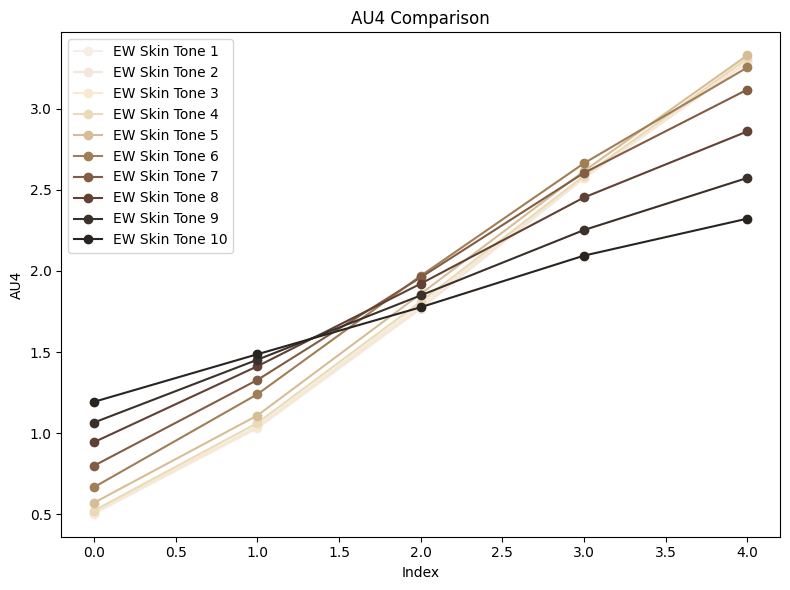

Results:
      DataFrame     Slope  Mean Absolute Difference
0   Skin Tone 1  0.709607                  0.000000
1   Skin Tone 2  0.708978                  0.006052
2   Skin Tone 3  0.711085                  0.015903
3   Skin Tone 4  0.709617                  0.028482
4   Skin Tone 5  0.701883                  0.066361
5   Skin Tone 6  0.659421                  0.140047
6   Skin Tone 7  0.590990                  0.197600
7   Skin Tone 8  0.486859                  0.303846
8   Skin Tone 9  0.381273                  0.419109
9  Skin Tone 10  0.286453                  0.518502


In [83]:
plot_columns_together1([m1_df, m1_2df, m1_3df, m1_4df, m1_5df, m1_6df, m1_7df, m1_8df, m1_9df, m1_10df], 'AU4', 'model1_au4.png')

Slope of DataFrame 1: 0.5367
Mean Absolute Difference from DataFrame 1: 0.0000
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.5408
Mean Absolute Difference from DataFrame 1: 0.0116
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 3: 0.5459
Mean Absolute Difference from DataFrame 1: 0.0273
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 4: 0.5564
Mean Absolute Difference from DataFrame 1: 0.0576
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 5: 0.5742
Mean Absolute Difference from DataFrame 1: 0.1216
Cosine Similarity with DataFrame 1: 0.9998

Slope of DataFrame 6: 0.6261
Mean Absolute Difference from DataFrame 1: 0.2578
Cosine Similarity with DataFrame 1: 0.9993

Slope of DataFrame 7: 0.6520
Mean Absolute Difference from DataFrame 1: 0.3538
Cosine Similarity with DataFrame 1: 0.9987

Slope of DataFrame 8: 0.6786
Mean Absolute Difference from DataFrame 1: 0.4987
Cosine Similarity with DataFrame 1: 0.9971

Slope of DataFra

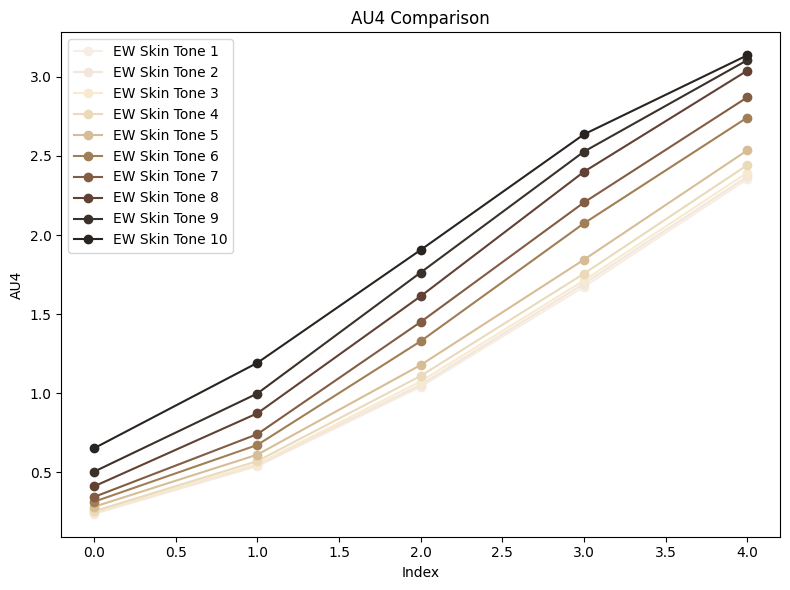

Results:
      DataFrame     Slope  Mean Absolute Difference
0   Skin Tone 1  0.536715                  0.000000
1   Skin Tone 2  0.540845                  0.011600
2   Skin Tone 3  0.545915                  0.027293
3   Skin Tone 4  0.556391                  0.057630
4   Skin Tone 5  0.574163                  0.121559
5   Skin Tone 6  0.626064                  0.257791
6   Skin Tone 7  0.652030                  0.353768
7   Skin Tone 8  0.678588                  0.498688
8   Skin Tone 9  0.673528                  0.611034
9  Skin Tone 10  0.641599                  0.735927


In [84]:
plot_columns_together1([m2_df, m2_2df, m2_3df, m2_4df, m2_5df, m2_6df, m2_7df, m2_8df, m2_9df, m2_10df], 'AU4', 'model2_au4.png')

Slope of DataFrame 1: 0.6446
Mean Absolute Difference from DataFrame 1: 0.0000
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.6486
Mean Absolute Difference from DataFrame 1: 0.0084
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 3: 0.6531
Mean Absolute Difference from DataFrame 1: 0.0204
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 4: 0.6666
Mean Absolute Difference from DataFrame 1: 0.0439
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 5: 0.6902
Mean Absolute Difference from DataFrame 1: 0.0987
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 6: 0.7498
Mean Absolute Difference from DataFrame 1: 0.2504
Cosine Similarity with DataFrame 1: 0.9998

Slope of DataFrame 7: 0.7822
Mean Absolute Difference from DataFrame 1: 0.3713
Cosine Similarity with DataFrame 1: 0.9995

Slope of DataFrame 8: 0.8003
Mean Absolute Difference from DataFrame 1: 0.5500
Cosine Similarity with DataFrame 1: 0.9978

Slope of DataFra

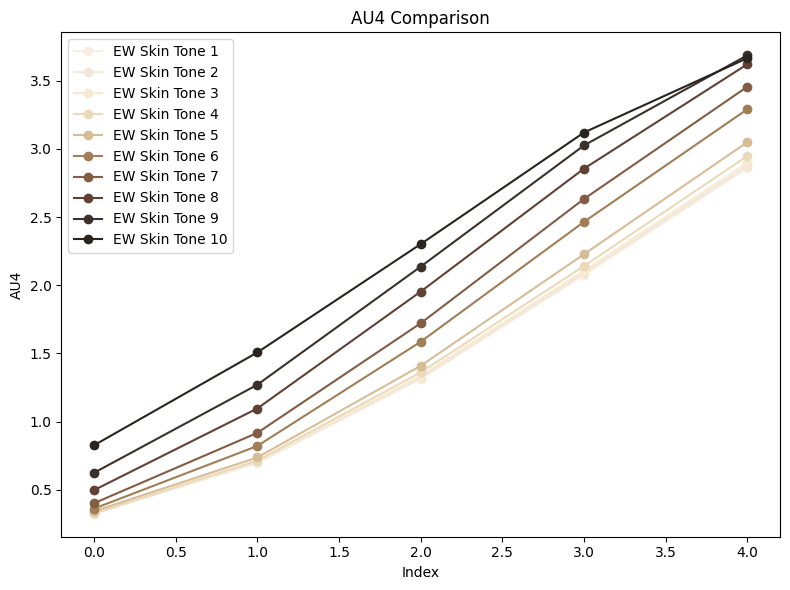

Results:
      DataFrame     Slope  Mean Absolute Difference
0   Skin Tone 1  0.644643                  0.000000
1   Skin Tone 2  0.648620                  0.008378
2   Skin Tone 3  0.653078                  0.020398
3   Skin Tone 4  0.666566                  0.043907
4   Skin Tone 5  0.690190                  0.098726
5   Skin Tone 6  0.749842                  0.250434
6   Skin Tone 7  0.782220                  0.371315
7   Skin Tone 8  0.800305                  0.550050
8   Skin Tone 9  0.787633                  0.694055
9  Skin Tone 10  0.728911                  0.829519


In [88]:
plot_columns_together1([m3_df, m3_2df, m3_3df, m3_4df, m3_5df, m3_6df, m3_7df, m3_8df, m3_9df, m3_10df], 'AU4')

Slope of DataFrame 1: 0.0277
Mean Absolute Difference from DataFrame 1: 0.0000
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.0265
Mean Absolute Difference from DataFrame 1: 0.0075
Cosine Similarity with DataFrame 1: 0.9997

Slope of DataFrame 3: 0.0292
Mean Absolute Difference from DataFrame 1: 0.0236
Cosine Similarity with DataFrame 1: 0.9965

Slope of DataFrame 4: 0.0338
Mean Absolute Difference from DataFrame 1: 0.0827
Cosine Similarity with DataFrame 1: 0.9384

Slope of DataFrame 5: 0.0452
Mean Absolute Difference from DataFrame 1: 0.2153
Cosine Similarity with DataFrame 1: -0.1767

Slope of DataFrame 6: 0.0490
Mean Absolute Difference from DataFrame 1: 0.2623
Cosine Similarity with DataFrame 1: -0.4848

Slope of DataFrame 7: 0.0533
Mean Absolute Difference from DataFrame 1: 0.2863
Cosine Similarity with DataFrame 1: -0.5714

Slope of DataFrame 8: 0.0505
Mean Absolute Difference from DataFrame 1: 0.2737
Cosine Similarity with DataFrame 1: -0.5810

Slope of Dat

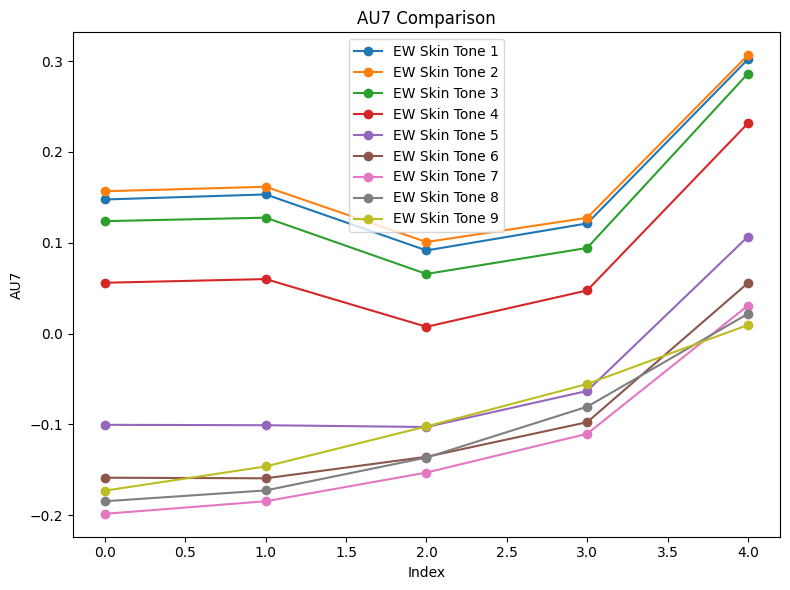

Results:
     DataFrame     Slope  Mean Absolute Difference
0  Skin Tone 1  0.027671                  0.000000
1  Skin Tone 2  0.026537                  0.007497
2  Skin Tone 3  0.029152                  0.023623
3  Skin Tone 4  0.033850                  0.082659
4  Skin Tone 5  0.045205                  0.215306
5  Skin Tone 6  0.049041                  0.262307
6  Skin Tone 7  0.053270                  0.286304
7  Skin Tone 8  0.050489                  0.273696
8  Skin Tone 9  0.045555                  0.256670


In [39]:
plot_columns_together1([m3_2df, m3_3df, m3_4df, m3_5df, m3_6df, m3_7df, m3_8df, m3_9df, m3_10df], 'AU7')

Slope of DataFrame 1: 0.0095
Mean Absolute Difference from DataFrame 1: 0.0000
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.0097
Mean Absolute Difference from DataFrame 1: 0.0007
Cosine Similarity with DataFrame 1: 0.9999

Slope of DataFrame 3: 0.0084
Mean Absolute Difference from DataFrame 1: 0.0044
Cosine Similarity with DataFrame 1: 0.9992

Slope of DataFrame 4: 0.0054
Mean Absolute Difference from DataFrame 1: 0.0132
Cosine Similarity with DataFrame 1: 0.9948

Slope of DataFrame 5: -0.0056
Mean Absolute Difference from DataFrame 1: 0.0216
Cosine Similarity with DataFrame 1: 0.9181

Slope of DataFrame 6: -0.0124
Mean Absolute Difference from DataFrame 1: 0.0265
Cosine Similarity with DataFrame 1: 0.8715

Slope of DataFrame 7: -0.0178
Mean Absolute Difference from DataFrame 1: 0.0364
Cosine Similarity with DataFrame 1: 0.8426

Slope of DataFrame 8: -0.0254
Mean Absolute Difference from DataFrame 1: 0.0479
Cosine Similarity with DataFrame 1: 0.7954

Slope of Dat

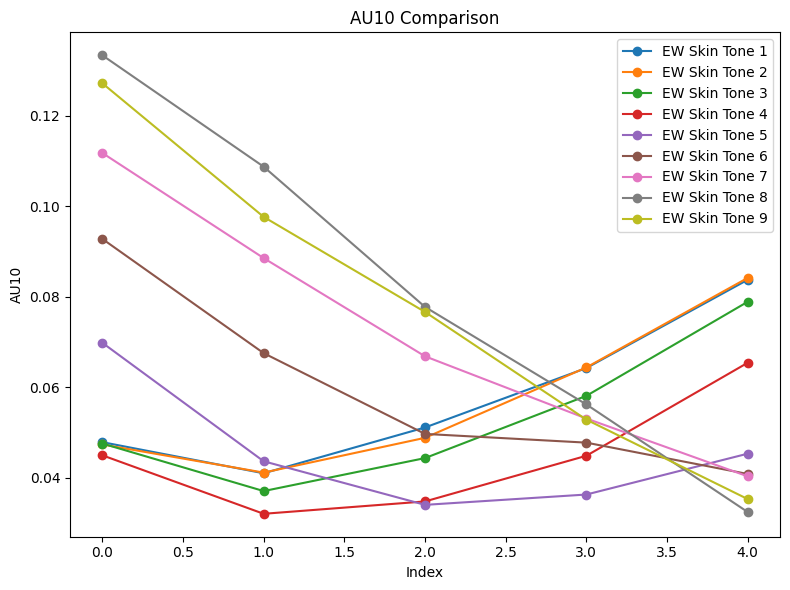

Results:
     DataFrame     Slope  Mean Absolute Difference
0  Skin Tone 1  0.009503                  0.000000
1  Skin Tone 2  0.009688                  0.000701
2  Skin Tone 3  0.008371                  0.004400
3  Skin Tone 4  0.005373                  0.013186
4  Skin Tone 5 -0.005637                  0.021622
5  Skin Tone 6 -0.012371                  0.026463
6  Skin Tone 7 -0.017841                  0.036362
7  Skin Tone 8 -0.025446                  0.047858
8  Skin Tone 9 -0.022863                  0.044280


In [40]:
plot_columns_together1([m3_2df, m3_3df, m3_4df, m3_5df, m3_6df, m3_7df, m3_8df, m3_9df, m3_10df], 'AU10')

trained on EM2-9

Slope of DataFrame 1: 0.7395
Mean Absolute Difference from DataFrame 1: 0.0000
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.7407
Mean Absolute Difference from DataFrame 1: 0.0067
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 3: 0.7443
Mean Absolute Difference from DataFrame 1: 0.0147
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 4: 0.7503
Mean Absolute Difference from DataFrame 1: 0.0376
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 5: 0.7634
Mean Absolute Difference from DataFrame 1: 0.0866
Cosine Similarity with DataFrame 1: 0.9999

Slope of DataFrame 6: 0.8021
Mean Absolute Difference from DataFrame 1: 0.2042
Cosine Similarity with DataFrame 1: 0.9995

Slope of DataFrame 7: 0.8230
Mean Absolute Difference from DataFrame 1: 0.3067
Cosine Similarity with DataFrame 1: 0.9988

Slope of DataFrame 8: 0.8306
Mean Absolute Difference from DataFrame 1: 0.4359
Cosine Similarity with DataFrame 1: 0.9967

Slope of DataFra

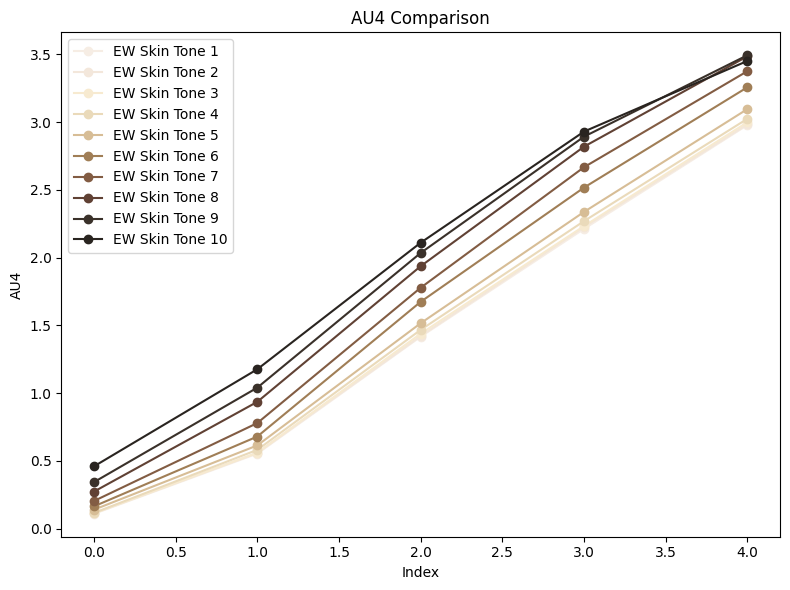

Results:
      DataFrame     Slope  Mean Absolute Difference
0   Skin Tone 1  0.739455                  0.000000
1   Skin Tone 2  0.740665                  0.006681
2   Skin Tone 3  0.744266                  0.014656
3   Skin Tone 4  0.750334                  0.037587
4   Skin Tone 5  0.763442                  0.086590
5   Skin Tone 6  0.802091                  0.204236
6   Skin Tone 7  0.823017                  0.306666
7   Skin Tone 8  0.830639                  0.435851
8   Skin Tone 9  0.815134                  0.506712
9  Skin Tone 10  0.773638                  0.571314


In [160]:
plot_columns_together1([m3_df, m3_2df, m3_3df, m3_4df, m3_5df, m3_6df, m3_7df, m3_8df, m3_9df, m3_10df], 'AU4')

trained on EM5-10

Slope of DataFrame 1: 0.7096
Mean Absolute Difference from DataFrame 1: 0.0000
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.2865
Mean Absolute Difference from DataFrame 1: 0.5185
Cosine Similarity with DataFrame 1: 0.9612



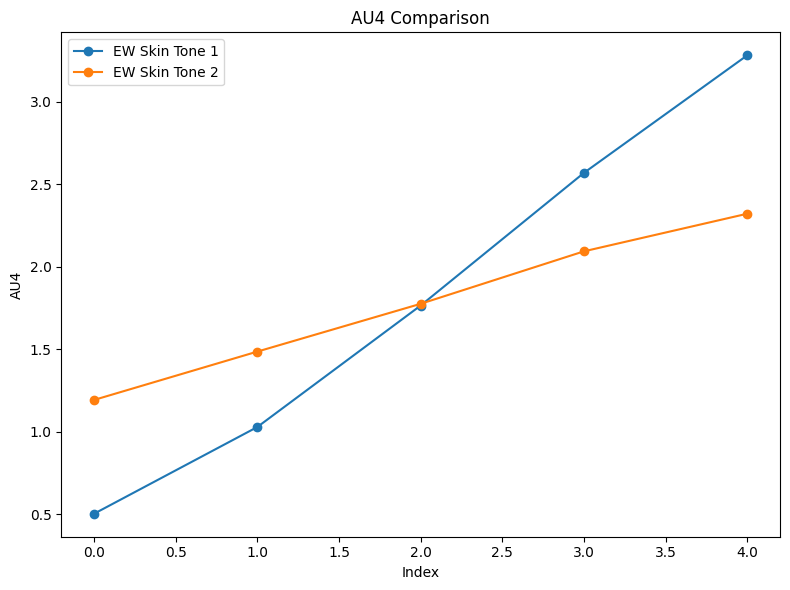

Results:
     DataFrame     Slope  Mean Absolute Difference
0  Skin Tone 1  0.709607                  0.000000
1  Skin Tone 2  0.286453                  0.518502


In [48]:
plot_columns_together1([m3_df, m3_10df], 'AU4')

trained on EM1-5

In [ ]:
# import os
# import cv2
# import pandas as pd
#
# def process_images(folder_path, model, device):
#     # List all files in the folder
#     files = os.listdir(folder_path)
#
#     # Filter files starting with '4' and exclude those starting with '43'
#     image_files = [file for file in files if file.startswith('4') and not file.startswith('43')]
#
#     # Initialize an empty list to hold the data
#     data = []
#     image_files = sorted(image_files)
#     image_files.append(image_files.pop(0))
#     for image_file in image_files:
#         # Read the image
#         image_path = os.path.join(folder_path, image_file)
#         image = cv2.imread(image_path)
#
#         # Process the image using the model
#         output = test_model(model, image, device)
#         output = output.flatten()
#
#         # Create a dictionary with the image name and output values
#         row = {
#             'Image': image_file,
#             'PSPI': output[0].item(),
#             'AU4': output[1].item(),
#             'AU6': output[2].item(),
#             'AU7': output[3].item(),
#             'AU9': output[4].item(),
#             'AU10': output[5].item(),
#             'AU12': output[6].item(),
#             'AU20': output[7].item(),
#             'AU25': output[8].item(),
#             'AU26': output[9].item(),
#             'AU43': output[10].item()
#         }
#
#         # Append the row to the data list
#         data.append(row)
#
#     # Create a DataFrame from the data list
#     df = pd.DataFrame(data)
#
#     # Print the DataFrame
#     #print(df)
#
#     # Return the DataFrame
#     return df


In [174]:
def plot_columns_together2(folder_path, column_name, model, device, save_path=None):
    color_scale = ['#f6ede4', '#f3e7db', '#f7ead0', '#eadaba', '#d7bd96', '#a07e56', '#825c43', '#604134', '#3a312a', '#292420']

    plt.figure(figsize=(8, 6))
    df_results = pd.DataFrame(columns=['DataFrame', 'Slope', 'Mean Absolute Difference', 'Mean Absolute Difference from True AU Activation'])

    folder_list = sorted([folder_name for folder_name in os.listdir(folder_path) if not folder_name.startswith('.')])

    # Move the second folder to the last
    folder_list.append(folder_list.pop(1))
    print(folder_list)

    first_folder = os.path.join(folder_path, folder_list[0])
    df_first = process_images(first_folder, model, device)  # Obtain the dataframe for the first folder

    for i, folder_name in enumerate(folder_list):
        current_folder = os.path.join(folder_path, folder_name)

        df = process_images(current_folder, model, device)  # Obtain the dataframe for the current folder

        values = df[column_name]

        # Calculate the mean absolute difference
        mean_abs_diff = np.mean(np.abs(values - df_first[column_name]))
        mean_abs_diff_from_true = np.mean(np.abs(values - range(1, len(values) + 1)))  # Updated calculation

        # Calculate the cosine similarity
        cosine_sim = cosine_similarity(values.values.reshape(1, -1),
                                       df_first[column_name].values.reshape(1, -1))[0, 0]

        # Perform linear regression on each dataset
        slope, _ = np.polyfit(range(len(values)), values, 1)
        print(f"Slope of DataFrame {i+1}: {slope:.4f}")
        print(f"Mean Absolute Difference from DataFrame 1: {mean_abs_diff:.4f}")
        print(f"Mean Absolute Difference from True AU Activation: {mean_abs_diff_from_true:.4f}")
        print(f"Cosine Similarity with DataFrame 1: {cosine_sim:.4f}")
        print()

        # Store the results in the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({'DataFrame': [f'Skin Tone {i+1}'],
                                                          'Slope': [slope],
                                                          'Mean Absolute Difference': [mean_abs_diff],
                                                          'Mean Absolute Difference from True AU Activation': [mean_abs_diff_from_true]})],
                               ignore_index=True)

        # Plot the values from the current DataFrame with the specified color
        plt.plot(range(1, len(values) + 1), values, label=f'EW Skin Tone {i+1}', marker='o', color=color_scale[i])

    plt.xlabel('True AU Activation')
    plt.ylabel('Pred AU Activation')
    plt.title(f"{column_name} Activation Comparison")
    plt.legend()
    plt.ylim(0, 5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)  # Save the plot to a PNG file

    plt.show()

    print("Results:")
    print(df_results)

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of DataFrame 1: 0.7096
Mean Absolute Difference from DataFrame 1: 0.0000
Mean Absolute Difference from True AU Activation: 1.1703
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.7090
Mean Absolute Difference from DataFrame 1: 0.0061
Mean Absolute Difference from True AU Activation: 1.1642
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 3: 0.7111
Mean Absolute Difference from DataFrame 1: 0.0159
Mean Absolute Difference from True AU Activation: 1.1544
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 4: 0.7096
Mean Absolute Difference from DataFrame 1: 0.0285
Mean Absolute Difference from True AU Activation: 1.1418
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 5: 0.7019
Mean Absolute Difference from DataFrame 1: 0.0664
Mean Absolute Difference from True AU Activation: 1.1039
Cosine Similarity with DataFrame 1: 0.9998

Slope of DataFrame 6: 0.6594

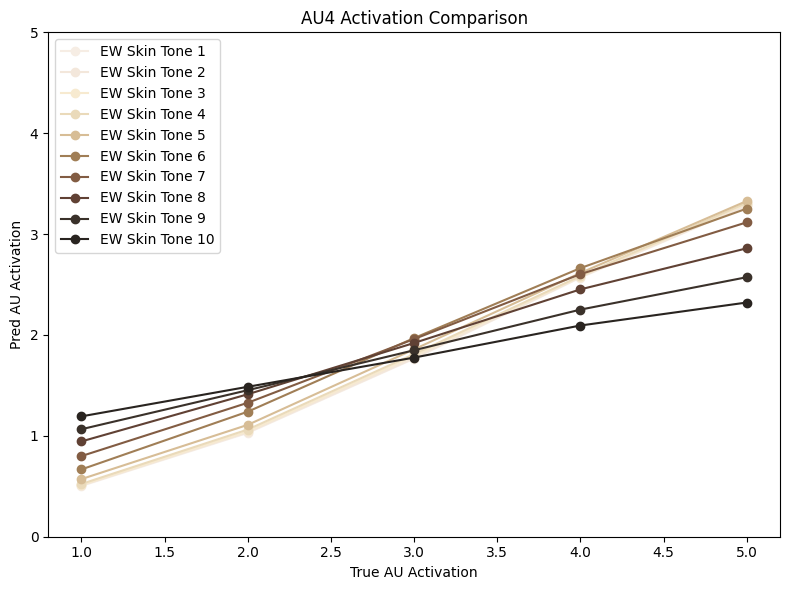

Results:
      DataFrame     Slope  Mean Absolute Difference   
0   Skin Tone 1  0.709607                  0.000000  \
1   Skin Tone 2  0.708978                  0.006052   
2   Skin Tone 3  0.711085                  0.015903   
3   Skin Tone 4  0.709617                  0.028482   
4   Skin Tone 5  0.701883                  0.066361   
5   Skin Tone 6  0.659421                  0.140047   
6   Skin Tone 7  0.590990                  0.197600   
7   Skin Tone 8  0.486859                  0.303846   
8   Skin Tone 9  0.381273                  0.419109   
9  Skin Tone 10  0.286453                  0.518502   

   Mean Absolute Difference from True AU Activation  
0                                          1.170270  
1                                          1.164218  
2                                          1.154366  
3                                          1.141788  
4                                          1.103909  
5                                          1.041698  
6      

In [175]:
plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU4', model1, device, 'model1_au4.png')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of DataFrame 1: 0.5367
Mean Absolute Difference from DataFrame 1: 0.0000
Mean Absolute Difference from True AU Activation: 1.8314
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.5408
Mean Absolute Difference from DataFrame 1: 0.0116
Mean Absolute Difference from True AU Activation: 1.8198
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 3: 0.5459
Mean Absolute Difference from DataFrame 1: 0.0273
Mean Absolute Difference from True AU Activation: 1.8041
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 4: 0.5564
Mean Absolute Difference from DataFrame 1: 0.0576
Mean Absolute Difference from True AU Activation: 1.7738
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 5: 0.5742
Mean Absolute Difference from DataFrame 1: 0.1216
Mean Absolute Difference from True AU Activation: 1.7098
Cosine Similarity with DataFrame 1: 0.9998

Slope of DataFrame 6: 0.6261

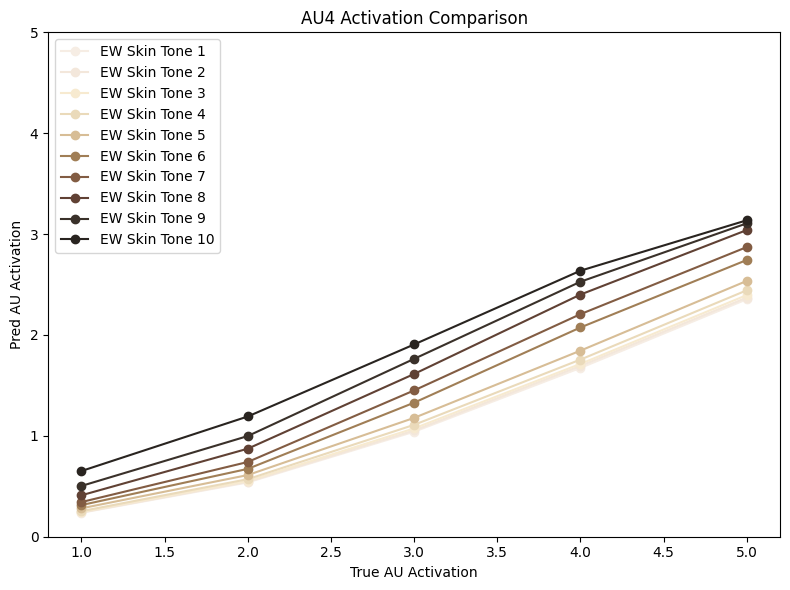

Results:
      DataFrame     Slope  Mean Absolute Difference   
0   Skin Tone 1  0.536715                  0.000000  \
1   Skin Tone 2  0.540845                  0.011600   
2   Skin Tone 3  0.545915                  0.027293   
3   Skin Tone 4  0.556391                  0.057630   
4   Skin Tone 5  0.574163                  0.121559   
5   Skin Tone 6  0.626064                  0.257791   
6   Skin Tone 7  0.652030                  0.353768   
7   Skin Tone 8  0.678588                  0.498688   
8   Skin Tone 9  0.673528                  0.611034   
9  Skin Tone 10  0.641599                  0.735927   

   Mean Absolute Difference from True AU Activation  
0                                          1.831405  
1                                          1.819805  
2                                          1.804112  
3                                          1.773775  
4                                          1.709846  
5                                          1.573614  
6      

In [176]:
plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU4', model2, device, 'model2_au4.png')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of DataFrame 1: 0.7395
Mean Absolute Difference from DataFrame 1: 0.0000
Mean Absolute Difference from True AU Activation: 1.5461
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 2: 0.7407
Mean Absolute Difference from DataFrame 1: 0.0067
Mean Absolute Difference from True AU Activation: 1.5394
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 3: 0.7443
Mean Absolute Difference from DataFrame 1: 0.0147
Mean Absolute Difference from True AU Activation: 1.5314
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 4: 0.7503
Mean Absolute Difference from DataFrame 1: 0.0376
Mean Absolute Difference from True AU Activation: 1.5085
Cosine Similarity with DataFrame 1: 1.0000

Slope of DataFrame 5: 0.7634
Mean Absolute Difference from DataFrame 1: 0.0866
Mean Absolute Difference from True AU Activation: 1.4595
Cosine Similarity with DataFrame 1: 0.9999

Slope of DataFrame 6: 0.8021

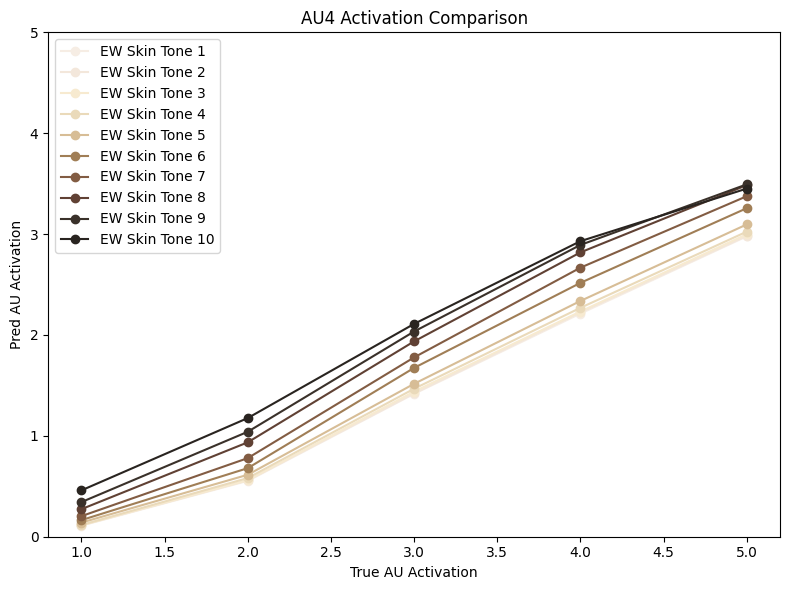

Results:
      DataFrame     Slope  Mean Absolute Difference   
0   Skin Tone 1  0.739455                  0.000000  \
1   Skin Tone 2  0.740665                  0.006681   
2   Skin Tone 3  0.744266                  0.014656   
3   Skin Tone 4  0.750334                  0.037587   
4   Skin Tone 5  0.763442                  0.086590   
5   Skin Tone 6  0.802091                  0.204236   
6   Skin Tone 7  0.823017                  0.306666   
7   Skin Tone 8  0.830639                  0.435851   
8   Skin Tone 9  0.815134                  0.506712   
9  Skin Tone 10  0.773638                  0.571314   

   Mean Absolute Difference from True AU Activation  
0                                          1.546094  
1                                          1.539413  
2                                          1.531437  
3                                          1.508507  
4                                          1.459503  
5                                          1.341858  
6      

In [177]:
plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU4', model3, device, 'model3_au4.png')

In [153]:
m3_df

,Image,PSPI,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU25,AU26,AU43
0,4ew1_4.2.png,0.168241,0.324422,-0.129586,0.026571,-0.037219,-0.003122,0.102418,0.240716,2.891034,-0.164864,0.033556
1,4ew1_4.4.png,0.478357,0.698103,-0.150771,0.005395,-0.073192,0.015020,0.070080,0.256729,2.858650,-0.170622,0.019286
2,4ew1_4.6.png,1.011401,1.314174,-0.189024,-0.013894,-0.131250,0.036027,0.058045,0.264645,2.769432,-0.177346,0.001787
3,4ew1_4.8.png,1.712601,2.075840,-0.203732,-0.017648,-0.205315,0.054684,0.075249,0.261269,2.642324,-0.184511,-0.023424
4,4ew1_4.10.png,2.533514,2.858768,-0.234799,0.073913,-0.260914,0.073294,0.080482,0.245600,2.509045,-0.191023,-0.036482
